In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from scipy.stats import wilcoxon

# Load your data and select variables for each model
# Assuming you have a DataFrame named 'data' containing your features and target column
total_input = pd.read_csv("/mnt/data/lijincheng/UKB/Olink/0627/prediction/total_input.csv")
# Select variables for each model
model1_vars = ['age', 'sex','ethnicity_g', 'BMI','edu_g','apoe_e4carrier']
model2_vars = ['NEFL', 'GFAP', 'BCAN','GDF15', 'PTPRN2','EGFR','LTBP2','BAG3','NPTXR','CD276']
model3_vars = model1_vars + model2_vars

total_vars = model3_vars + ["allcause","time_year"]

data = total_input[total_vars]
# Use the map function to replace 'M' with 1 and 'F' with 0
data.loc[:, 'sex'] = data['sex'].map({'M': 1, 'F': 0})
data.loc[:, 'ethnicity_g'] = data['ethnicity_g'].apply(lambda x: 1 if x == 'White' else 0)
data.loc[:, 'edu_g'] = data['edu_g'].apply(lambda x: 1 if x == 'high' else 0)
data.loc[:, 'apoe_e4carrier'] = data['apoe_e4carrier'].apply(lambda x: 1 if x == '>=1' else 0)
data.loc[:, 'allcause'] = data['allcause'].apply(lambda x: 0 if x == 2 else x)
data.head()

,age,sex,ethnicity_g,BMI,edu_g,apoe_e4carrier,NEFL,GFAP,BCAN,GDF15,PTPRN2,EGFR,LTBP2,BAG3,NPTXR,CD276,allcause,time_year
0,56,1,1,35.7696,1,0,-1.442318,-0.212247,-0.445464,1.864294,-0.983766,-1.044434,2.307050,-1.217570,-0.627894,2.430995,0,11.931507
1,47,0,1,27.4298,1,1,0.719608,-1.427446,0.032161,-1.037625,-0.487651,1.332304,-0.356445,-1.244577,4.149903,-0.890600,0,13.871233
2,47,0,1,45.2390,1,0,-2.443579,-0.970073,-1.614627,-0.601873,-0.237409,1.160092,-0.602830,0.910404,-0.815504,-1.295208,0,12.852055
3,60,0,1,31.7083,1,0,-1.287934,-0.937560,-2.070173,-0.549016,-1.899682,-0.180433,0.470190,-0.726609,-1.758913,0.696398,0,13.509589
4,64,0,1,32.5333,0,0,-0.328452,1.363423,0.526712,-0.467624,-0.132561,-1.656268,-1.128914,-0.181743,-0.048984,0.329365,0,14.315068


              Model        P-value
0  Model 1 - Model2   2.357635e-31
1  Model 1 - Model3   0.000000e+00
2   Model2 - Model3  1.429979e-190


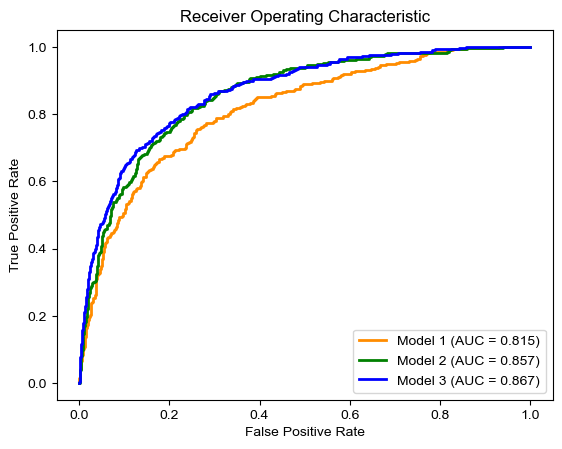

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['font.sans-serif'] = "Arial"
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data, data['allcause'], test_size=0.25, random_state=1005)

# Build and train model1
model1 = LogisticRegression(random_state=1005,max_iter=1000,class_weight='balanced')
model1.fit(X_train[model1_vars], y_train)

# Build and train model2
model2 = LogisticRegression(random_state=1005,max_iter=1000,class_weight='balanced')
model2.fit(X_train[model2_vars], y_train)

# Build and train model3
model3 = LogisticRegression(random_state=1005,max_iter=1000,class_weight='balanced')
model3.fit(X_train[model3_vars], y_train)

# Predict probabilities on validation set for each model
y_pred_prob_model1 = model1.predict_proba(X_val[model1_vars])[:, 1]
y_pred_prob_model2 = model2.predict_proba(X_val[model2_vars])[:, 1]
y_pred_prob_model3 = model3.predict_proba(X_val[model3_vars])[:, 1]

# Calculate AUC for each model
auc_model1 = roc_auc_score(y_val, y_pred_prob_model1)
auc_model2 = roc_auc_score(y_val, y_pred_prob_model2)
auc_model3 = roc_auc_score(y_val, y_pred_prob_model3)

# Perform Wilcoxon rank-sum test
statistic1, p_value1 = wilcoxon(y_pred_prob_model1-y_pred_prob_model2)
statistic2, p_value2 = wilcoxon(y_pred_prob_model1-y_pred_prob_model3)
statistic3, p_value3 = wilcoxon(y_pred_prob_model2-y_pred_prob_model3)

# Define a function to calculate performance metrics
def calculate_metrics(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True)
    return conf_matrix, report

# Calculate performance metrics for each model
conf_matrix_model1, report_model1 = calculate_metrics(y_val, (y_pred_prob_model1 > 0.5).astype(int))
conf_matrix_model3, report_model3 = calculate_metrics(y_val, (y_pred_prob_model3 > 0.5).astype(int))

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Model': ['Model 1 - Model2', 'Model 1 - Model3',"Model2 - Model3"],
    'P-value': [p_value1, p_value2,p_value3],
})

# Print and display the results DataFrame
print(results_df)


# 计算每个模型的 ROC 曲线
fpr1, tpr1, _ = roc_curve(y_val, y_pred_prob_model1)

fpr2, tpr2, _ = roc_curve(y_val, y_pred_prob_model2)

fpr3, tpr3, _ = roc_curve(y_val, y_pred_prob_model3)



# 创建一个 Matplotlib 图形
plt.figure()

# 绘制每个模型的 ROC 曲线
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label='Model 1 (AUC = %0.3f)' % auc_model1)
plt.plot(fpr2, tpr2, color='green', lw=2, label='Model 2 (AUC = %0.3f)' % auc_model2)
plt.plot(fpr3, tpr3, color='blue', lw=2, label='Model 3 (AUC = %0.3f)' % auc_model3)

# 填充置信区间


# 设置图形的标题和标签
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# 显示 ROC 曲线图
plt.show()

In [3]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample

np.random.seed(1005)
# Number of bootstrap iterations
n_bootstraps = 1000

# Placeholder to store ROC AUC scores from bootstrapped samples
bootstrapped_roc_aucs = []

for _ in range(n_bootstraps):
    # Resample the predictions with replacement
    boot_indices = np.random.choice(len(y_val), size=len(y_val), replace=True)
    boot_y_pred_prob = y_pred_prob_model1[boot_indices]
    boot_y_val = y_val.iloc[boot_indices]

    # Calculate ROC AUC for the bootstrapped sample
    boot_roc_auc = roc_auc_score(boot_y_val, boot_y_pred_prob)
    bootstrapped_roc_aucs.append(boot_roc_auc)

# Calculate the confidence interval from bootstrapped ROC AUC scores
confidence_interval1 = np.percentile(bootstrapped_roc_aucs, [2.5, 97.5])

# Print the calculated ROC AUC and confidence interval
print(f"model1 ROC AUC: {auc_model1:.3f}")
print(f"Confidence Interval: {confidence_interval1[0]:.3f} - {confidence_interval1[1]:.3f}")

# Print the calculated ROC AUC and confidence interval
# Define a function to calculate performance metrics
def calculate_metrics(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True)
    return conf_matrix, report

# Calculate performance metrics for each model
conf_matrix_model1, report_model1 = calculate_metrics(y_val, (y_pred_prob_model1 > 0.5).astype(int))
conf_matrix_model3, report_model3 = calculate_metrics(y_val, (y_pred_prob_model3 > 0.5).astype(int))

# Calculate TP, TN, FP, FN from the confusion matrix
TP = conf_matrix_model1[1, 1]
TN = conf_matrix_model1[0, 0]
FP = conf_matrix_model1[0, 1]
FN = conf_matrix_model1[1, 0]

# Calculate Sensitivity (Recall)
sensitivity = TP / (TP + FN)

# Calculate Specificity
specificity = TN / (TN + FP)

# Calculate Negative Predictive Value (NPV)
npv = TN / (TN + FN)

# Calculate Positive Predictive Value (PPV)
ppv = TP / (TP + FP)

# Print the calculated evaluation metrics
print(f"Sensitivity (Recall): {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"Negative Predictive Value (NPV): {npv:.3f}")
print(f"Positive Predictive Value (PPV): {ppv:.3f}")
print(report_model1)

model1 ROC AUC: 0.815
Confidence Interval: 0.788 - 0.838
Sensitivity (Recall): 0.783
Specificity: 0.697
Negative Predictive Value (NPV): 0.992
Positive Predictive Value (PPV): 0.060
{'0': {'precision': 0.9924013991074659, 'recall': 0.6971699711913235, 'f1-score': 0.8189916886477878, 'support': 11802.0}, '1': {'precision': 0.05972112601946856, 'recall': 0.7827586206896552, 'f1-score': 0.1109753116597409, 'support': 290.0}, 'accuracy': 0.6992226265299372, 'macro avg': {'precision': 0.5260612625634673, 'recall': 0.7399642959404893, 'f1-score': 0.46498350015376433, 'support': 12092.0}, 'weighted avg': {'precision': 0.9700331160115745, 'recall': 0.6992226265299372, 'f1-score': 0.8020114745122823, 'support': 12092.0}}


In [4]:
# Number of bootstrap iterations
np.random.seed(1005)
n_bootstraps = 1000

# Placeholder to store ROC AUC scores from bootstrapped samples
bootstrapped_roc_aucs = []

for _ in range(n_bootstraps):
    # Resample the predictions with replacement
    boot_indices = np.random.choice(len(y_val), size=len(y_val), replace=True)
    boot_y_pred_prob = y_pred_prob_model2[boot_indices]
    boot_y_val = y_val.iloc[boot_indices]

    # Calculate ROC AUC for the bootstrapped sample
    boot_roc_auc = roc_auc_score(boot_y_val, boot_y_pred_prob)
    bootstrapped_roc_aucs.append(boot_roc_auc)

# Calculate the confidence interval from bootstrapped ROC AUC scores
confidence_interval2 = np.percentile(bootstrapped_roc_aucs, [2.5, 97.5])

# Print the calculated ROC AUC and confidence interval
print(f"model2 ROC AUC: {auc_model2:.3f}")
print(f"Confidence Interval: {confidence_interval2[0]:.3f} - {confidence_interval2[1]:.3f}")

# Print the calculated ROC AUC and confidence interval
# Define a function to calculate performance metrics
def calculate_metrics(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True)
    return conf_matrix, report

# Calculate performance metrics for each model
conf_matrix_model1, report_model1 = calculate_metrics(y_val, (y_pred_prob_model1 > 0.5).astype(int))
conf_matrix_model2, report_model2 = calculate_metrics(y_val, (y_pred_prob_model2 > 0.5).astype(int))
conf_matrix_model3, report_model3 = calculate_metrics(y_val, (y_pred_prob_model3 > 0.5).astype(int))

# Calculate TP, TN, FP, FN from the confusion matrix
TP = conf_matrix_model2[1, 1]
TN = conf_matrix_model2[0, 0]
FP = conf_matrix_model2[0, 1]
FN = conf_matrix_model2[1, 0]

# Calculate Sensitivity (Recall)
sensitivity = TP / (TP + FN)

# Calculate Specificity
specificity = TN / (TN + FP)

# Calculate Negative Predictive Value (NPV)
npv = TN / (TN + FN)

# Calculate Positive Predictive Value (PPV)
ppv = TP / (TP + FP)

# Print the calculated evaluation metrics
print(f"Sensitivity (Recall): {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"Negative Predictive Value (NPV): {npv:.3f}")
print(f"Positive Predictive Value (PPV): {ppv:.3f}")
print(report_model2)

model2 ROC AUC: 0.857
Confidence Interval: 0.837 - 0.876
Sensitivity (Recall): 0.786
Specificity: 0.773
Negative Predictive Value (NPV): 0.993
Positive Predictive Value (PPV): 0.078
{'0': {'precision': 0.9932505987372088, 'recall': 0.7730893068971361, 'f1-score': 0.8694492090718506, 'support': 11802.0}, '1': {'precision': 0.07845836200963524, 'recall': 0.7862068965517242, 'f1-score': 0.14267834793491863, 'support': 290.0}, 'accuracy': 0.7734039034072114, 'macro avg': {'precision': 0.535854480373422, 'recall': 0.7796481017244301, 'f1-score': 0.5060637785033846, 'support': 12092.0}, 'weighted avg': {'precision': 0.9713113208137061, 'recall': 0.7734039034072114, 'f1-score': 0.8520192099211964, 'support': 12092.0}}


In [5]:
# Number of bootstrap iterations
np.random.seed(1005)
n_bootstraps = 1000

# Placeholder to store ROC AUC scores from bootstrapped samples
bootstrapped_roc_aucs = []

for _ in range(n_bootstraps):
    # Resample the predictions with replacement
    boot_indices = np.random.choice(len(y_val), size=len(y_val), replace=True)
    boot_y_pred_prob = y_pred_prob_model3[boot_indices]
    boot_y_val = y_val.iloc[boot_indices]

    # Calculate ROC AUC for the bootstrapped sample
    boot_roc_auc = roc_auc_score(boot_y_val, boot_y_pred_prob)
    bootstrapped_roc_aucs.append(boot_roc_auc)

# Calculate the confidence interval from bootstrapped ROC AUC scores
confidence_interval3 = np.percentile(bootstrapped_roc_aucs, [2.5, 97.5])

# Print the calculated ROC AUC and confidence interval
print(f"model3 ROC AUC: {auc_model3:.3f}")
print(f"Confidence Interval: {confidence_interval3[0]:.3f} - {confidence_interval3[1]:.3f}")

# Print the calculated ROC AUC and confidence interval
# Define a function to calculate performance metrics
def calculate_metrics(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True)
    return conf_matrix, report

# Calculate performance metrics for each model
conf_matrix_model1, report_model1 = calculate_metrics(y_val, (y_pred_prob_model1 > 0.5).astype(int))
conf_matrix_model2, report_model2 = calculate_metrics(y_val, (y_pred_prob_model2 > 0.5).astype(int))
conf_matrix_model3, report_model3 = calculate_metrics(y_val, (y_pred_prob_model3 > 0.5).astype(int))

# Calculate TP, TN, FP, FN from the confusion matrix
TP = conf_matrix_model3[1, 1]
TN = conf_matrix_model3[0, 0]
FP = conf_matrix_model3[0, 1]
FN = conf_matrix_model3[1, 0]

# Calculate Sensitivity (Recall)
sensitivity = TP / (TP + FN)

# Calculate Specificity
specificity = TN / (TN + FP)

# Calculate Negative Predictive Value (NPV)
npv = TN / (TN + FN)

# Calculate Positive Predictive Value (PPV)
ppv = TP / (TP + FP)

# Print the calculated evaluation metrics
print(f"Sensitivity (Recall): {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"Negative Predictive Value (NPV): {npv:.3f}")
print(f"Positive Predictive Value (PPV): {ppv:.3f}")
print(report_model3)


model3 ROC AUC: 0.867
Confidence Interval: 0.846 - 0.886
Sensitivity (Recall): 0.797
Specificity: 0.773
Negative Predictive Value (NPV): 0.994
Positive Predictive Value (PPV): 0.080
{'0': {'precision': 0.9935778817894851, 'recall': 0.7734282325029656, 'f1-score': 0.8697889370622707, 'support': 11802.0}, '1': {'precision': 0.07951807228915662, 'recall': 0.7965517241379311, 'f1-score': 0.14460093896713613, 'support': 290.0}, 'accuracy': 0.7739827985444923, 'macro avg': {'precision': 0.5365479770393209, 'recall': 0.7849899783204484, 'f1-score': 0.5071949380147034, 'support': 12092.0}, 'weighted avg': {'precision': 0.9716561695206218, 'recall': 0.7739827985444923, 'f1-score': 0.8523968993970715, 'support': 12092.0}}


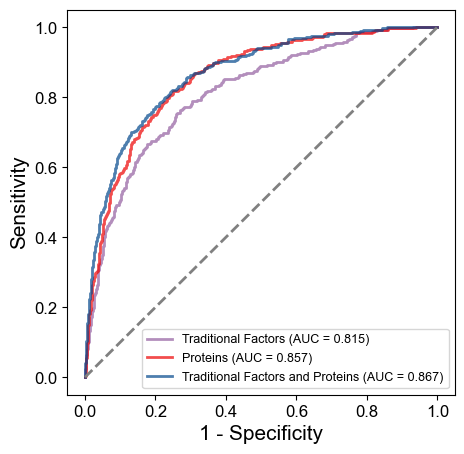

In [6]:
# 创建一个 Matplotlib 图形
plt.figure(figsize=(5, 5)) 

# 绘制每个模型的 ROC 曲线
#plt.plot(fpr1, tpr1, color='darkorange', lw=2, label='Model 1 AUC = %0.3f(0.788 - 0.838)' % auc_model1)
#plt.plot(fpr2, tpr2, color='green', lw=2, label='Model 2 AUC = %0.3f(0.837 - 0.876)' % auc_model2)
#plt.plot(fpr3, tpr3, color='blue', lw=2, label='Model 3 AUC = %0.3f(0.846 - 0.886)' % auc_model3)
plt.rcParams['font.sans-serif'] = "Arial"
plt.plot(fpr1, tpr1, color='#925E9FB2', lw=2, label='Traditional Factors (AUC = %0.3f)' % auc_model1)
plt.plot(fpr2, tpr2, color='#ED0000B2', lw=2, label='Proteins (AUC = %0.3f)' % auc_model2)
plt.plot(fpr3, tpr3, color='#00468BB2', lw=2, label='Traditional Factors and Proteins (AUC = %0.3f)' % auc_model3)

# 绘制对角线
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')

# 设置图形的标题和标签
#plt.title("ACD",fontsize=20)  # fontname="Arial"
plt.xlabel('1 - Specificity',fontsize=15) #False Positive Rate
plt.ylabel('Sensitivity',fontsize=15) #True Positive Rate
plt.legend(loc='lower right',fontsize=9)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
# Save the figure to a file (e.g., 'roc_plot.png')
plt.savefig('allcause_roc_3models.pdf',dpi=1200)
# 显示 ROC 曲线图
plt.show()

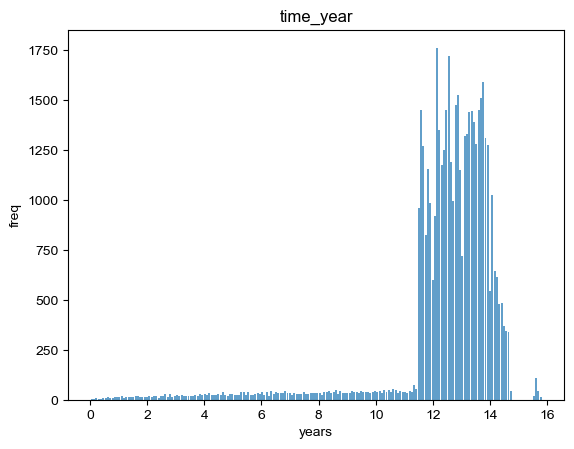

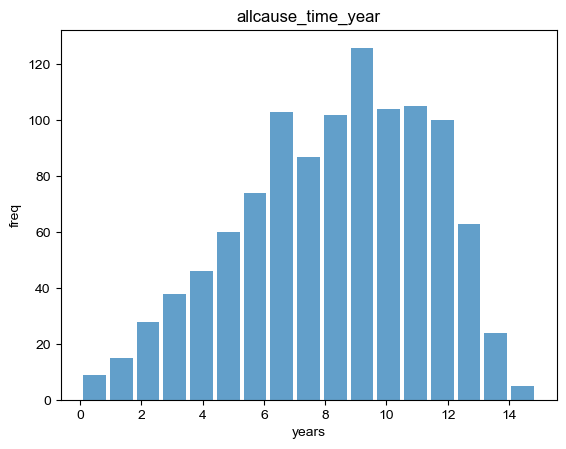

allcause max 14.8821917808219
total max 15.8082191780822


In [7]:
plt.hist(total_input['time_year'], bins='auto', alpha=0.7, rwidth=0.85)
plt.title('time_year')
plt.xlabel('years')
plt.ylabel('freq')
plt.show()

plt.hist(total_input[total_input['allcause']==1]['time_year'], bins='auto', alpha=0.7, rwidth=0.85)
plt.title('allcause_time_year')
plt.xlabel('years')
plt.ylabel('freq')
plt.show()

print("allcause max",total_input[total_input['allcause'] == 1]['time_year'].max())
print("total max",total_input['time_year'].max())

In [8]:
X_val.head()


,age,sex,ethnicity_g,BMI,edu_g,apoe_e4carrier,NEFL,GFAP,BCAN,GDF15,PTPRN2,EGFR,LTBP2,BAG3,NPTXR,CD276,allcause,time_year
32544,56,0,1,25.2598,1,0,0.314908,-0.948215,-0.452333,-0.531225,-0.912366,-0.266806,-0.324090,-0.601782,-0.923220,1.109111,0,12.602740
3392,63,1,0,27.8081,1,0,1.116239,0.261884,0.026273,1.092317,-0.273587,-0.130160,0.146390,-0.082387,0.462158,-0.080646,0,12.991781
45881,55,1,0,25.6005,1,0,-0.446975,-0.248494,1.357342,-0.382364,0.330653,-0.351040,0.338129,0.741005,0.439440,0.916200,0,12.961644
3637,65,0,1,22.7528,1,0,1.334099,0.894757,0.890266,0.008695,2.073063,-1.955767,1.428645,-0.048244,0.908720,-1.985559,0,13.638356
11786,64,0,0,23.9463,1,0,-0.126730,-0.577271,-0.406950,-0.290229,0.068534,-0.289001,-0.374421,-0.153199,-0.226383,-0.736124,0,11.989041


In [9]:
y_val.shape

(12092,)

In [10]:
##df.loc[(df.team == 'A') & (df.position == 'G')]
#X_train, X_val, y_train, y_val = train_test_split(data, data['allcause'], test_size=0.25, random_state=1005)
caseall = X_val
years0_5 = X_val[(X_val['allcause'] == 0) | ((X_val['allcause'] == 1) & (X_val['time_year'] < 5))]
years5_10 = X_val[(X_val['allcause'] == 0) | ((X_val['allcause'] == 1) & ((X_val['time_year'] > 5) | (X_val['time_year'] == 5)) & (X_val['time_year'] <10) )]
years10_15 = X_val[(X_val['allcause'] == 0) | ((X_val['allcause'] == 1) & ((X_val['time_year'] > 10) | (X_val['time_year'] == 10)) & (X_val['time_year'] <15) )]

print("testset: ",caseall.shape)
print("years0_5: ",years0_5.shape)
print("years5_10: ",years5_10.shape)
print("years10_15: ",years10_15.shape)

# Predict probabilities on validation set for each model

y_pred_prob_model2_caseall  = model2.predict_proba(caseall[model2_vars])[:, 1]
y_pred_prob_model2_years0_5 = model2.predict_proba(years0_5[model2_vars])[:, 1]
y_pred_prob_model2_years5_10 = model2.predict_proba(years5_10[model2_vars])[:, 1]
y_pred_prob_model2_years10_15 = model2.predict_proba(years10_15[model2_vars])[:, 1]




testset:  (12092, 18)
years0_5:  (11854, 18)
years5_10:  (11942, 18)
years10_15:  (11900, 18)


In [11]:
#### healthy; total diagnosis; 0-3;3-6;6-9;9-12;12-15

# Split the data into training and validation sets
#healthy = total_input[total_input['allcause'] == 0]
# Calculate AUC for each model
auc_caseall = roc_auc_score(caseall['allcause'], y_pred_prob_model2_caseall)
auc_years0_5 = roc_auc_score(years0_5['allcause'], y_pred_prob_model2_years0_5)
auc_years5_10 = roc_auc_score(years5_10['allcause'], y_pred_prob_model2_years5_10)
auc_years10_15 = roc_auc_score(years10_15['allcause'], y_pred_prob_model2_years10_15)


In [12]:

# 计算每个模型的 ROC 曲线
fpr_caseall, tpr_caseall, _ = roc_curve(caseall['allcause'], y_pred_prob_model2_caseall)
fpr_years0_5, tpr_years0_5, _ = roc_curve(years0_5['allcause'], y_pred_prob_model2_years0_5)
fpr_years5_10, tpr_years5_10, _ = roc_curve(years5_10['allcause'], y_pred_prob_model2_years5_10)
fpr_years10_15, tpr_years10_15, _ = roc_curve(years10_15['allcause'], y_pred_prob_model2_years10_15)




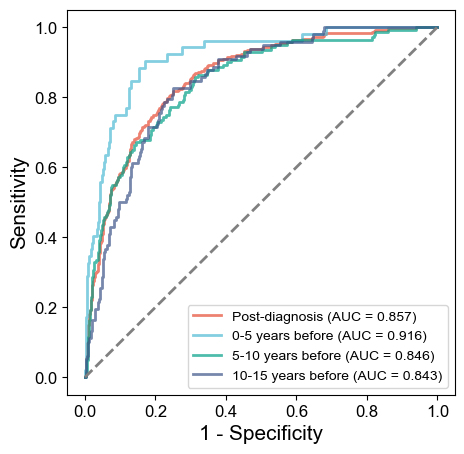

In [13]:
# 创建一个 Matplotlib 图形

plt.figure(figsize=(5, 5)) 
# 绘制每个模型的 ROC 曲线
plt.plot(fpr_caseall, tpr_caseall, color='#E64B34B2', lw=2, label='Post-diagnosis (AUC = %0.3f)' % auc_caseall)
plt.plot(fpr_years0_5, tpr_years0_5, color='#4DBBD5B2', lw=2, label='0-5 years before (AUC = %0.3f)' % auc_years0_5)
plt.plot(fpr_years5_10, tpr_years5_10, color='#00A087B2', lw=2, label='5-10 years before (AUC = %0.3f)' % auc_years5_10)
plt.plot(fpr_years10_15, tpr_years10_15, color='#3C5488B2', lw=2, label='10-15 years before (AUC = %0.3f)' % auc_years10_15)

# 绘制对角线
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
# 填充置信区间

# 设置图形的标题和标签
#plt.title('Receiver Operating Characteristic')
#plt.title("ACD",fontsize=20)  # fontname="Arial"
plt.xlabel('1 - Specificity',fontsize=15) #False Positive Rate
plt.ylabel('Sensitivity',fontsize=15) #True Positive Rate
plt.legend(loc='lower right',fontsize=12)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc='lower right')
plt.savefig('allcause_5years_prediect1.pdf',dpi=1200)
# 显示 ROC 曲线图
plt.show()

In [14]:
####add 95%ci
# Number of bootstrap iterations
np.random.seed(1005)
n_bootstraps = 1000
# Placeholder to store ROC AUC scores from bootstrapped samples
bootstrapped_roc_aucs = []

for _ in range(n_bootstraps):
    # Resample the predictions with replacement
    boot_indices = np.random.choice(len(years0_5['allcause']), size=len(years0_5['allcause']), replace=True)
    boot_y_pred_prob = y_pred_prob_model2_years0_5[boot_indices]
    boot_y_val = years0_5['allcause'].iloc[boot_indices]

    # Calculate ROC AUC for the bootstrapped sample
    boot_roc_auc = roc_auc_score(boot_y_val, boot_y_pred_prob)
    bootstrapped_roc_aucs.append(boot_roc_auc)

# Calculate the confidence interval from bootstrapped ROC AUC scores
confidence_interval_years0_5 = np.percentile(bootstrapped_roc_aucs, [2.5, 97.5])

# Print the calculated ROC AUC and confidence interval
print(f"years0_5 ROC AUC: {auc_years0_5:.3f}")
print(f"Confidence Interval: {confidence_interval_years0_5[0]:.3f} - {confidence_interval_years0_5[1]:.3f}")

# Print the calculated ROC AUC and confidence interval
# Define a function to calculate performance metrics
def calculate_metrics(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True)
    return conf_matrix, report

# Calculate performance metrics for each model    years0_5['allcause'], y_pred_prob_model2_years0_5
conf_matrix_years0_5, report_years0_5 = calculate_metrics(years0_5['allcause'], (y_pred_prob_model2_years0_5 > 0.5).astype(int))
conf_matrix_years5_10, report_years5_10 = calculate_metrics(years5_10['allcause'], (y_pred_prob_model2_years5_10 > 0.5).astype(int))
conf_matrix_years10_15, report_years10_15 = calculate_metrics(years10_15['allcause'], (y_pred_prob_model2_years10_15 > 0.5).astype(int))

# Calculate TP, TN, FP, FN from the confusion matrix
TP = conf_matrix_years0_5[1, 1]
TN = conf_matrix_years0_5[0, 0]
FP = conf_matrix_years0_5[0, 1]
FN = conf_matrix_years0_5[1, 0]

# Calculate Sensitivity (Recall)
sensitivity = TP / (TP + FN)

# Calculate Specificity
specificity = TN / (TN + FP)

# Calculate Negative Predictive Value (NPV)
npv = TN / (TN + FN)

# Calculate Positive Predictive Value (PPV)
ppv = TP / (TP + FP)

# Print the calculated evaluation metrics
print(f"Sensitivity (Recall): {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"Negative Predictive Value (NPV): {npv:.3f}")
print(f"Positive Predictive Value (PPV): {ppv:.3f}")
print(report_years0_5)




years0_5 ROC AUC: 0.916
Confidence Interval: 0.879 - 0.948
Sensitivity (Recall): 0.904
Specificity: 0.773
Negative Predictive Value (NPV): 0.999
Positive Predictive Value (PPV): 0.017
{'0': {'precision': 0.9994522948844342, 'recall': 0.7730893068971361, 'f1-score': 0.8718169222684057, 'support': 11802.0}, '1': {'precision': 0.01724770642201835, 'recall': 0.9038461538461539, 'f1-score': 0.03384947785379906, 'support': 52.0}, 'accuracy': 0.7736628985996288, 'macro avg': {'precision': 0.5083500006532263, 'recall': 0.838467730371645, 'f1-score': 0.4528332000611024, 'support': 11854.0}, 'weighted avg': {'precision': 0.9951436531938618, 'recall': 0.7736628985996288, 'f1-score': 0.8681410063657938, 'support': 11854.0}}


In [15]:
####add 95%ci
# Number of bootstrap iterations
np.random.seed(1005)
n_bootstraps = 1000
# Placeholder to store ROC AUC scores from bootstrapped samples
bootstrapped_roc_aucs = []

for _ in range(n_bootstraps):
    # Resample the predictions with replacement
    boot_indices = np.random.choice(len(years5_10['allcause']), size=len(years5_10['allcause']), replace=True)
    boot_y_pred_prob = y_pred_prob_model2_years5_10[boot_indices]
    boot_y_val = years5_10['allcause'].iloc[boot_indices]

    # Calculate ROC AUC for the bootstrapped sample
    boot_roc_auc = roc_auc_score(boot_y_val, boot_y_pred_prob)
    bootstrapped_roc_aucs.append(boot_roc_auc)

# Calculate the confidence interval from bootstrapped ROC AUC scores
confidence_interval_years5_10 = np.percentile(bootstrapped_roc_aucs, [2.5, 97.5])

# Print the calculated ROC AUC and confidence interval
print(f"years5_10 ROC AUC: {auc_years5_10:.3f}")
print(f"Confidence Interval: {confidence_interval_years5_10[0]:.3f} - {confidence_interval_years5_10[1]:.3f}")

# Print the calculated ROC AUC and confidence interval
# Define a function to calculate performance metrics
def calculate_metrics(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True)
    return conf_matrix, report

# Calculate performance metrics for each model    years0_5['allcause'], y_pred_prob_model2_years0_5
conf_matrix_years0_5, report_years0_5 = calculate_metrics(years0_5['allcause'], (y_pred_prob_model2_years0_5 > 0.5).astype(int))
conf_matrix_years5_10, report_years5_10 = calculate_metrics(years5_10['allcause'], (y_pred_prob_model2_years5_10 > 0.5).astype(int))
conf_matrix_years10_15, report_years10_15 = calculate_metrics(years10_15['allcause'], (y_pred_prob_model2_years10_15 > 0.5).astype(int))

# Calculate TP, TN, FP, FN from the confusion matrix
TP = conf_matrix_years5_10[1, 1]
TN = conf_matrix_years5_10[0, 0]
FP = conf_matrix_years5_10[0, 1]
FN = conf_matrix_years5_10[1, 0]

# Calculate Sensitivity (Recall)
sensitivity = TP / (TP + FN)

# Calculate Specificity
specificity = TN / (TN + FP)

# Calculate Negative Predictive Value (NPV)
npv = TN / (TN + FN)

# Calculate Positive Predictive Value (PPV)
ppv = TP / (TP + FP)

# Print the calculated evaluation metrics
print(f"Sensitivity (Recall): {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"Negative Predictive Value (NPV): {npv:.3f}")
print(f"Positive Predictive Value (PPV): {ppv:.3f}")
print(report_years5_10)




years5_10 ROC AUC: 0.846
Confidence Interval: 0.812 - 0.877
Sensitivity (Recall): 0.743
Specificity: 0.773
Negative Predictive Value (NPV): 0.996
Positive Predictive Value (PPV): 0.037
{'0': {'precision': 0.9960698689956332, 'recall': 0.7730893068971361, 'f1-score': 0.8705276214101707, 'support': 11802.0}, '1': {'precision': 0.037383177570093455, 'recall': 0.7428571428571429, 'f1-score': 0.07118412046543462, 'support': 140.0}, 'accuracy': 0.7727348852788478, 'macro avg': {'precision': 0.5167265232828633, 'recall': 0.7579732248771395, 'f1-score': 0.4708558709378027, 'support': 11942.0}, 'weighted avg': {'precision': 0.9848308690961544, 'recall': 0.7727348852788478, 'f1-score': 0.8611566542244178, 'support': 11942.0}}


In [16]:
####add 95%ci
# Number of bootstrap iterations
np.random.seed(1005)
n_bootstraps = 1000
# Placeholder to store ROC AUC scores from bootstrapped samples
bootstrapped_roc_aucs = []

for _ in range(n_bootstraps):
    # Resample the predictions with replacement
    boot_indices = np.random.choice(len(years10_15['allcause']), size=len(years10_15['allcause']), replace=True)
    boot_y_pred_prob = y_pred_prob_model2_years10_15[boot_indices]
    boot_y_val = years10_15['allcause'].iloc[boot_indices]

    # Calculate ROC AUC for the bootstrapped sample
    boot_roc_auc = roc_auc_score(boot_y_val, boot_y_pred_prob)
    bootstrapped_roc_aucs.append(boot_roc_auc)

# Calculate the confidence interval from bootstrapped ROC AUC scores
confidence_interval_years10_15 = np.percentile(bootstrapped_roc_aucs, [2.5, 97.5])

# Print the calculated ROC AUC and confidence interval
print(f"years10_15 ROC AUC: {auc_years10_15:.3f}")
print(f"Confidence Interval: {confidence_interval_years10_15[0]:.3f} - {confidence_interval_years10_15[1]:.3f}")

# Print the calculated ROC AUC and confidence interval
# Define a function to calculate performance metrics
def calculate_metrics(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True)
    return conf_matrix, report

# Calculate performance metrics for each model    years0_5['allcause'], y_pred_prob_model2_years0_5
conf_matrix_years0_5, report_years0_5 = calculate_metrics(years0_5['allcause'], (y_pred_prob_model2_years0_5 > 0.5).astype(int))
conf_matrix_years5_10, report_years5_10 = calculate_metrics(years5_10['allcause'], (y_pred_prob_model2_years5_10 > 0.5).astype(int))
conf_matrix_years10_15, report_years10_15 = calculate_metrics(years10_15['allcause'], (y_pred_prob_model2_years10_15 > 0.5).astype(int))

# Calculate TP, TN, FP, FN from the confusion matrix
TP = conf_matrix_years10_15[1, 1]
TN = conf_matrix_years10_15[0, 0]
FP = conf_matrix_years10_15[0, 1]
FN = conf_matrix_years10_15[1, 0]

# Calculate Sensitivity (Recall)
sensitivity = TP / (TP + FN)

# Calculate Specificity
specificity = TN / (TN + FP)

# Calculate Negative Predictive Value (NPV)
npv = TN / (TN + FN)

# Calculate Positive Predictive Value (PPV)
ppv = TP / (TP + FP)

# Print the calculated evaluation metrics
print(f"Sensitivity (Recall): {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"Negative Predictive Value (NPV): {npv:.3f}")
print(f"Positive Predictive Value (PPV): {ppv:.3f}")
print(report_years10_15)




years10_15 ROC AUC: 0.843
Confidence Interval: 0.811 - 0.874
Sensitivity (Recall): 0.786
Specificity: 0.773
Negative Predictive Value (NPV): 0.998
Positive Predictive Value (PPV): 0.028
{'0': {'precision': 0.9977036632039366, 'recall': 0.7730893068971361, 'f1-score': 0.8711510001432187, 'support': 11802.0}, '1': {'precision': 0.0279491833030853, 'recall': 0.7857142857142857, 'f1-score': 0.053978268489309505, 'support': 98.0}, 'accuracy': 0.7731932773109244, 'macro avg': {'precision': 0.5128264232535109, 'recall': 0.7794017963057109, 'f1-score': 0.4625646343162641, 'support': 11900.0}, 'weighted avg': {'precision': 0.9897174498400473, 'recall': 0.7731932773109244, 'f1-score': 0.8644213423531276, 'support': 11900.0}}


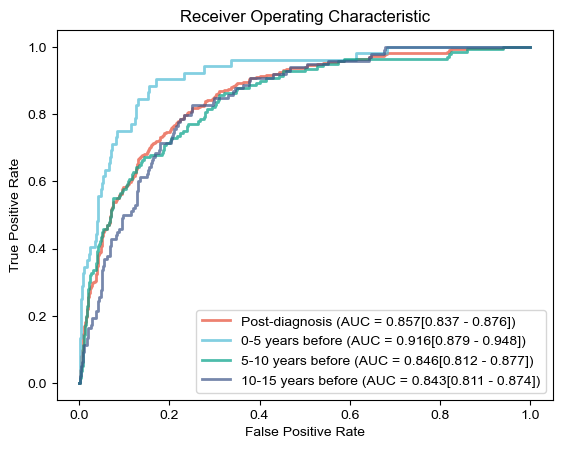

In [17]:
# 创建一个 Matplotlib 图形
plt.figure()

# 绘制每个模型的 ROC 曲线
plt.plot(fpr_caseall, tpr_caseall, color='#E64B34B2', lw=2, label='Post-diagnosis (AUC = %0.3f[0.837 - 0.876])' % auc_caseall)
plt.plot(fpr_years0_5, tpr_years0_5, color='#4DBBD5B2', lw=2, label='0-5 years before (AUC = %0.3f[0.879 - 0.948])' % auc_years0_5)
plt.plot(fpr_years5_10, tpr_years5_10, color='#00A087B2', lw=2, label='5-10 years before (AUC = %0.3f[0.812 - 0.877])' % auc_years5_10)
plt.plot(fpr_years10_15, tpr_years10_15, color='#3C5488B2', lw=2, label='10-15 years before (AUC = %0.3f[0.811 - 0.874])' % auc_years10_15)


# 填充置信区间

# 设置图形的标题和标签
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.savefig('allcause_5years_prediect2.pdf')
# 显示 ROC 曲线图
plt.show()

In [18]:
healthy_bee = X_val[(X_val['allcause'] == 0)]
caseall_bee = X_val[(X_val['allcause'] == 1)]
years0_5_bee = X_val[((X_val['allcause'] == 1) & (X_val['time_year'] < 5))]
years5_10_bee = X_val[ ((X_val['allcause'] == 1) & ((X_val['time_year'] > 5) | (X_val['time_year'] == 5)) & (X_val['time_year'] <10) )]
years10_15_bee = X_val[ ((X_val['allcause'] == 1) & ((X_val['time_year'] > 10) | (X_val['time_year'] == 10)) & (X_val['time_year'] <15) )]


y_pred_prob_model2_healthy_bee  = model2.predict_proba(healthy_bee[model2_vars])[:, 1]
y_pred_prob_model2_caseall_bee  = model2.predict_proba(caseall_bee[model2_vars])[:, 1]
y_pred_prob_model2_years0_5_bee = model2.predict_proba(years0_5_bee[model2_vars])[:, 1]
y_pred_prob_model2_years5_10_bee = model2.predict_proba(years5_10_bee[model2_vars])[:, 1]
y_pred_prob_model2_years10_15_bee = model2.predict_proba(years10_15_bee[model2_vars])[:, 1]

print('healthy_bee',healthy_bee.shape)
print('caseall_bee',caseall_bee.shape)
print('years0_5_bee',years0_5_bee.shape)
print('years5_10_bee',years5_10_bee.shape)
print('years10_15_bee',years10_15_bee.shape)

healthy_bee (11802, 18)
caseall_bee (290, 18)
years0_5_bee (52, 18)
years5_10_bee (140, 18)
years10_15_bee (98, 18)


In [19]:
# Create a DataFrame to store the results
scores_df = pd.DataFrame({
    'Model': ['Healthy\n(n=11802)', 'Post-diagnosis\n(n=290)',"0-5 years before\n(n=52)",
              "5-10 years before\n(n=140)","10-15 years before\n(n=98)"],
    'Scores': [y_pred_prob_model2_healthy_bee, y_pred_prob_model2_caseall_bee,y_pred_prob_model2_years0_5_bee,
             y_pred_prob_model2_years5_10_bee,y_pred_prob_model2_years10_15_bee],
})
scores_df.head()


,Model,Scores
0,Healthy\n(n=11802),"[0.33833830435354684, 0.5706277033533108, 0.11..."
1,Post-diagnosis\n(n=290),"[0.30357668009204763, 0.9662843329809411, 0.48..."
2,0-5 years before\n(n=52),"[0.9662843329809411, 0.8801554709860618, 0.823..."
3,5-10 years before\n(n=140),"[0.4872806198069512, 0.48422207572680726, 0.89..."
4,10-15 years before\n(n=98),"[0.30357668009204763, 0.6989040920236743, 0.14..."


In [20]:
# 使用 explode 将列表中的值展开
scores_df_exploded = scores_df.explode('Scores')

# 重新设置索引
scores_df_exploded.reset_index(drop=True, inplace=True)
scores_df_exploded.head()

,Model,Scores
0,Healthy\n(n=11802),0.338338
1,Healthy\n(n=11802),0.570628
2,Healthy\n(n=11802),0.119412
3,Healthy\n(n=11802),0.52636
4,Healthy\n(n=11802),0.183051


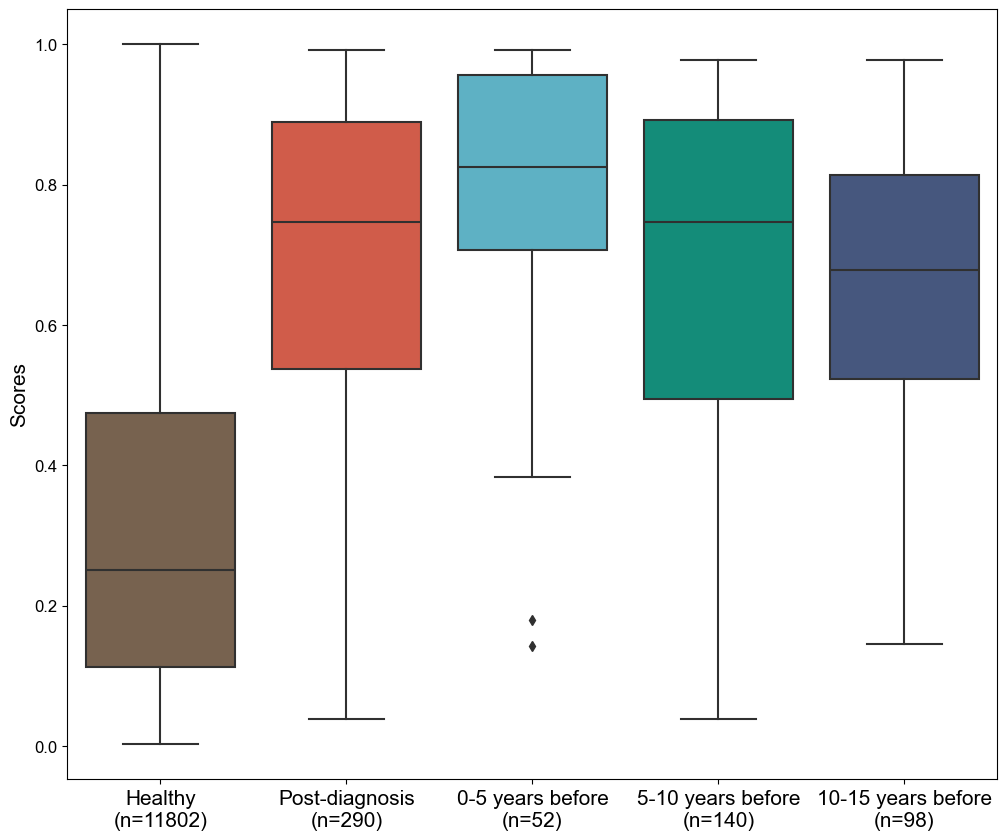

In [21]:
plt.figure(figsize=(12, 10))  # 8表示宽度，4表示高度
ax =sns.boxplot(x="Model", y="Scores", data=scores_df_exploded,palette=['#7E6148B2','#E64B34B2','#4DBBD5B2','#00A087B2','#3C5488B2'])
plt.xlabel('')
ax.set_ylabel('Scores', fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=12)
plt.savefig('allcause_5years_scores.pdf',dpi=1200)
plt.show()

In [22]:
scores_df_exploded.to_csv('scores_5years.csv', index=False)